CROP RECOMMENDATION SYSTEM
Machine Learning for Agriculture
Dataset Shape: (28242, 8)

First few rows:
   Unnamed: 0     Area         Item  Year  hg/ha_yield  \
0           0  Albania        Maize  1990        36613   
1           1  Albania     Potatoes  1990        66667   
2           2  Albania  Rice, paddy  1990        23333   
3           3  Albania      Sorghum  1990        12500   
4           4  Albania     Soybeans  1990         7000   

   average_rain_fall_mm_per_year  pesticides_tonnes  avg_temp  
0                         1485.0              121.0     16.37  
1                         1485.0              121.0     16.37  
2                         1485.0              121.0     16.37  
3                         1485.0              121.0     16.37  
4                         1485.0              121.0     16.37  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28242 entries, 0 to 28241
Data columns (total 8 columns):
 #   Column                         Non-N

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/

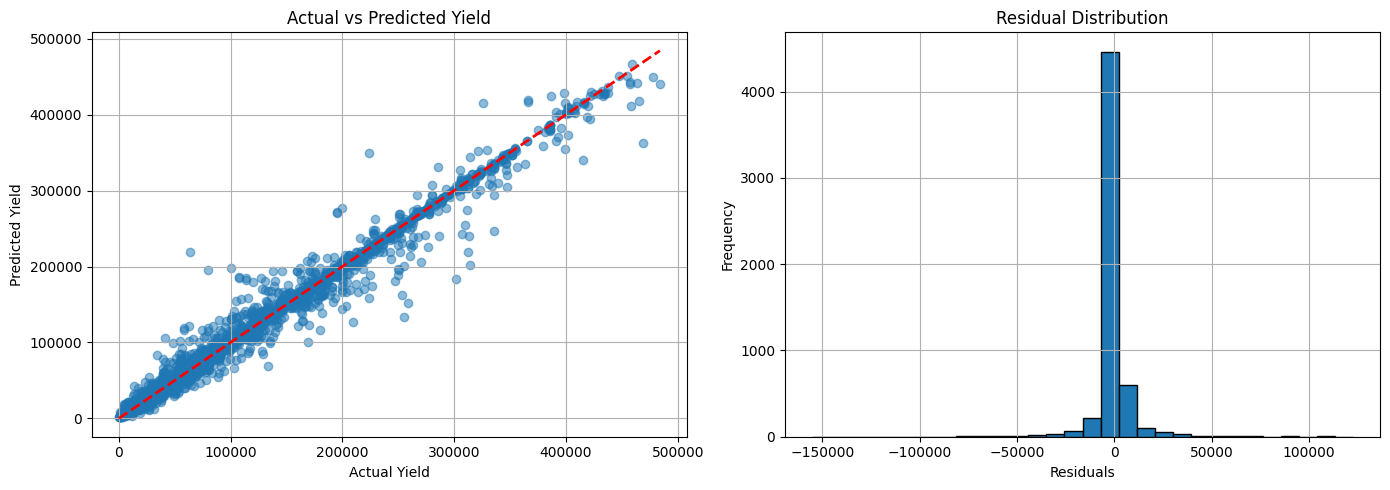

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

class CropRecommendationSystem:
    def __init__(self):
        self.yield_model = None
        self.disease_model = None
        self.scaler = StandardScaler()
        self.label_encoders = {}

    def load_data(self, filepath):
        df = pd.read_csv(filepath)
        print("Dataset Shape:", df.shape)
        print("\nFirst few rows:")
        print(df.head())
        print("\nDataset Info:")
        print(df.info())
        print("\nStatistical Summary:")
        print(df.describe())
        return df

    def preprocess_data(self, df):
        df_processed = df.copy()

        if 'Area' in df_processed.columns:
            self.label_encoders['Area'] = LabelEncoder()
            df_processed['Area_encoded'] = self.label_encoders['Area'].fit_transform(df_processed['Area'])

        if 'Item' in df_processed.columns:
            self.label_encoders['Item'] = LabelEncoder()
            df_processed['Item_encoded'] = self.label_encoders['Item'].fit_transform(df_processed['Item'])

        print("\nEncoded Categories:")
        if 'Area' in df_processed.columns:
            print("Areas:", dict(enumerate(self.label_encoders['Area'].classes_)))
        if 'Item' in df_processed.columns:
            print("Items:", dict(enumerate(self.label_encoders['Item'].classes_)))

        return df_processed

    def train_yield_prediction(self, df):
        print("\n" + "="*60)
        print("TRAINING YIELD PREDICTION MODEL")
        print("="*60)

        feature_cols = ['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
        if 'Area_encoded' in df.columns:
            feature_cols.append('Area_encoded')
        if 'Item_encoded' in df.columns:
            feature_cols.append('Item_encoded')

        X = df[feature_cols]
        y = df['hg/ha_yield']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        self.yield_model = RandomForestRegressor(n_estimators=100, random_state=42)
        self.yield_model.fit(X_train_scaled, y_train)

        y_pred = self.yield_model.predict(X_test_scaled)

        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        print(f"\nYield Prediction Results:")
        print(f"RMSE: {rmse:.2f}")
        print(f"R² Score: {r2:.4f}")

        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': self.yield_model.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nFeature Importance:")
        print(feature_importance)

        return X_test_scaled, y_test, y_pred

    def create_disease_labels(self, df):
        conditions = [
            (df['hg/ha_yield'] < df['hg/ha_yield'].quantile(0.25)),
            (df['hg/ha_yield'] >= df['hg/ha_yield'].quantile(0.25)) &
            (df['hg/ha_yield'] < df['hg/ha_yield'].quantile(0.75)),
            (df['hg/ha_yield'] >= df['hg/ha_yield'].quantile(0.75))
        ]
        labels = ['High Risk', 'Medium Risk', 'Low Risk']
        df['disease_risk'] = np.select(conditions, labels, default='Unknown Risk') # Added default string value
        return df

    def train_disease_detection(self, df):
        print("\n" + "="*60)
        print("TRAINING DISEASE DETECTION MODEL")
        print("="*60)

        df = self.create_disease_labels(df)

        feature_cols = ['Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
        if 'Area_encoded' in df.columns:
            feature_cols.append('Area_encoded')
        if 'Item_encoded' in df.columns:
            feature_cols.append('Item_encoded')

        X = df[feature_cols]
        y = df['disease_risk']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        self.disease_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
        self.disease_model.fit(X_train, y_train)

        y_pred = self.disease_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)

        print(f"\nDisease Detection Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        return X_test, y_test, y_pred

    def recommend_crop(self, area, year, rainfall, pesticides, avg_temp):
        print("\n" + "="*60)
        print("CROP RECOMMENDATION")
        print("="*60)

        recommendations = []

        area_encoded = self.label_encoders['Area'].transform([area])[0]

        for item in self.label_encoders['Item'].classes_:
            item_encoded = self.label_encoders['Item'].transform([item])[0]

            features = np.array([[year, rainfall, pesticides, avg_temp, area_encoded, item_encoded]])
            features_scaled = self.scaler.transform(features)

            predicted_yield = self.yield_model.predict(features_scaled)[0]

            disease_features = np.array([[year, predicted_yield, rainfall, pesticides, avg_temp, area_encoded, item_encoded]])
            disease_risk = self.disease_model.predict(disease_features)[0]

            recommendations.append({
                'Crop': item,
                'Predicted_Yield': predicted_yield,
                'Disease_Risk': disease_risk
            })

        recommendations_df = pd.DataFrame(recommendations)
        recommendations_df = recommendations_df.sort_values('Predicted_Yield', ascending=False)

        print(f"\nRecommendations for {area} in {year}:")
        print(f"Rainfall: {rainfall} mm/year")
        print(f"Pesticides: {pesticides} tonnes")
        print(f"Temperature: {avg_temp}°C")
        print("\n" + recommendations_df.to_string(index=False))

        return recommendations_df

    def visualize_results(self, y_test, y_pred):
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        axes[0].scatter(y_test, y_pred, alpha=0.5)
        axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[0].set_xlabel('Actual Yield')
        axes[0].set_ylabel('Predicted Yield')
        axes[0].set_title('Actual vs Predicted Yield')
        axes[0].grid(True)

        residuals = y_test - y_pred
        axes[1].hist(residuals, bins=30, edgecolor='black')
        axes[1].set_xlabel('Residuals')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Residual Distribution')
        axes[1].grid(True)

        plt.tight_layout()
        plt.savefig('yield_prediction_results.png')
        print("\nVisualization saved as 'yield_prediction_results.png'")

def main():
    print("="*60)
    print("CROP RECOMMENDATION SYSTEM")
    print("Machine Learning for Agriculture")
    print("="*60)

    system = CropRecommendationSystem()

    df = system.load_data('RS-A1_yield.csv')

    df_processed = system.preprocess_data(df)

    X_test, y_test, y_pred = system.train_yield_prediction(df_processed)

    X_test_disease, y_test_disease, y_pred_disease = system.train_disease_detection(df_processed)

    system.visualize_results(y_test, y_pred)

    recommendations = system.recommend_crop(
        area='Albania',
        year=1992,
        rainfall=1485,
        pesticides=121,
        avg_temp=16.0
    )

    print("\n" + "="*60)
    print("SYSTEM TRAINING COMPLETE")
    print("="*60)

if __name__ == "__main__":
    main()

In [ ]:
"""
================================================================================
CROP DISEASE DETECTION & YIELD PREDICTION SYSTEM
Machine Learning Concepts and Implementation
================================================================================

KEY CONCEPTS USED:

1. SUPERVISED LEARNING:
   - Learning from labeled data (we have input features and known outputs)
   - Two types used here:
     a) Regression: Predicting continuous values (yield in hg/ha)
     b) Classification: Predicting categories (disease risk levels)

2. RANDOM FOREST REGRESSOR:
   - Ensemble method: Combines multiple decision trees
   - Each tree is trained on random subset of data (bootstrap sampling)
   - Final prediction = average of all trees
   - Advantages: Reduces overfitting, handles non-linear relationships
   - Parameters:
     * n_estimators: Number of trees in forest (more trees = better but slower)
     * random_state: Seed for reproducibility

3. GRADIENT BOOSTING CLASSIFIER:
   - Sequential ensemble method: Trees built one after another
   - Each new tree corrects errors of previous trees
   - Uses gradient descent to minimize loss function
   - Better for classification tasks with multiple classes
   - Advantages: High accuracy, handles complex patterns

4. LABEL ENCODING:
   - Converts categorical text data into numerical format
   - Example: 'Albania' → 0, 'Algeria' → 1, etc.
   - ML models need numbers, not text
   - Each unique category gets a unique integer

5. STANDARD SCALER (FEATURE SCALING):
   - Normalizes features to have mean=0 and std=1
   - Formula: z = (x - mean) / std_deviation
   - Why needed: Different features have different scales
     * Year: 1990-2020
     * Rainfall: 100-3000 mm
     * Temperature: 5-35°C
   - Prevents features with larger values from dominating the model

6. TRAIN-TEST SPLIT:
   - Divides data into training (80%) and testing (20%) sets
   - Training set: Used to teach the model
   - Testing set: Used to evaluate model on unseen data
   - Prevents overfitting and checks generalization

7. EVALUATION METRICS:

   For REGRESSION (Yield Prediction):
   a) MSE (Mean Squared Error): Average of squared differences
      - Formula: MSE = Σ(actual - predicted)² / n
      - Lower is better

   b) RMSE (Root Mean Squared Error): Square root of MSE
      - Formula: RMSE = √MSE
      - Same units as target variable
      - Easier to interpret than MSE

   c) R² Score (Coefficient of Determination):
      - Measures how well model explains variance in data
      - Range: 0 to 1 (can be negative for bad models)
      - R² = 1: Perfect prediction
      - R² = 0.8+: Good model
      - R² = 0: Model no better than average

   For CLASSIFICATION (Disease Detection):
   a) Accuracy: Percentage of correct predictions
      - Formula: (Correct Predictions / Total Predictions) × 100

   b) Precision: Of predicted positives, how many are actually positive
      - Formula: True Positives / (True Positives + False Positives)

   c) Recall: Of actual positives, how many did we predict
      - Formula: True Positives / (True Positives + False Negatives)

   d) F1-Score: Harmonic mean of precision and recall
      - Formula: 2 × (Precision × Recall) / (Precision + Recall)

8. FEATURE IMPORTANCE:
   - Shows which features contribute most to predictions
   - In Random Forest: Based on reduction in impurity
   - Helps understand what drives yield predictions
   - Example: Temperature might be more important than pesticides

9. CONFUSION MATRIX CONCEPTS:
   - True Positive (TP): Correctly predicted positive class
   - True Negative (TN): Correctly predicted negative class
   - False Positive (FP): Incorrectly predicted positive (Type I error)
   - False Negative (FN): Incorrectly predicted negative (Type II error)

10. CROSS-VALIDATION CONCEPT (not implemented but important):
    - Multiple train-test splits to get robust performance estimate
    - K-Fold: Data divided into k parts, each part used as test once
    - Reduces variance in performance estimates

11. OVERFITTING vs UNDERFITTING:
    - Overfitting: Model memorizes training data, fails on new data
      * High training accuracy, low test accuracy
      * Solution: More data, simpler model, regularization

    - Underfitting: Model too simple to capture patterns
      * Low training accuracy, low test accuracy
      * Solution: More complex model, more features

12. FEATURE ENGINEERING:
    - Creating new features from existing ones
    - Here: Creating 'disease_risk' categories from yield values
    - Using quantiles (25%, 75%) to define risk levels

13. RECOMMENDATION SYSTEM LOGIC:
    - For each crop type:
      1. Predict expected yield
      2. Predict disease risk based on yield
      3. Rank crops by predicted yield
    - Helps farmers choose best crop for their conditions

14. RESIDUALS:
    - Difference between actual and predicted values
    - Residual = Actual - Predicted
    - Ideally: Should be randomly distributed around 0
    - Pattern in residuals = model missing something

15. BIAS-VARIANCE TRADEOFF:
    - Bias: Error from wrong assumptions (underfitting)
    - Variance: Error from sensitivity to training data (overfitting)
    - Goal: Balance both for optimal performance

================================================================================

"""
"""
        Train Random Forest model to predict crop yield

        Process:
        1. SELECT FEATURES (X): Input variables that influence yield
           - Year, rainfall, pesticides, temperature, area, crop type

        2. SELECT TARGET (y): What we want to predict
           - hg/ha_yield (crop yield in hectograms per hectare)

        3. TRAIN-TEST SPLIT: Divide data
           - 80% training: Teach the model
           - 20% testing: Evaluate on unseen data
           - random_state=42: Ensures same split every time (reproducibility)

        4. FEATURE SCALING: Normalize all features
           - Brings all features to same scale (mean=0, std=1)
           - Prevents large-valued features from dominating
           - Example: Year (1990) vs Rainfall (1500) - very different scales

        5. TRAIN MODEL: Random Forest learns patterns
           - Creates 100 decision trees
           - Each tree trained on random subset of data
           - Final prediction = average of all trees

        6. EVALUATE: Test on unseen data
           - RMSE: Average prediction error in same units as yield
           - R²: How much variance in data is explained (0-1 scale)

        7. FEATURE IMPORTANCE: Which factors matter most
           - Shows contribution of each feature to predictions
           - Helps understand what drives crop yield
        """
"""
        Create disease risk categories from yield data

        Logic:
        - Low yield → High disease risk (crop not doing well)
        - Medium yield → Medium disease risk
        - High yield → Low disease risk (healthy crop)

        Method: Using Quantiles (Percentiles)
        - 25th percentile: Bottom 25% of yields = High Risk
        - 25th to 75th percentile: Middle 50% = Medium Risk
        - 75th percentile+: Top 25% of yields = Low Risk

        This is FEATURE ENGINEERING: Creating new meaningful features
        """
"""
        Train Gradient Boosting model to classify disease risk

        Process:
        1. CREATE LABELS: Convert yield to risk categories
           - Classification needs discrete classes

        2. SELECT FEATURES: Include yield as it indicates plant health
           - All environmental factors + predicted/actual yield

        3. GRADIENT BOOSTING CLASSIFIER:
           - Sequential ensemble: Builds trees one by one
           - Each tree corrects mistakes of previous trees
           - Uses gradient descent optimization
           - Better than Random Forest for classification

        4. EVALUATION METRICS:
           - Accuracy: Overall correctness percentage
           - Precision: Of predicted High Risk, how many actually High Risk
           - Recall: Of actual High Risk, how many we caught
           - F1-Score: Balance between precision and recall

        5. CLASSIFICATION REPORT:
           - Shows per-class performance
           - Support: Number of samples in each class
        """
"""
        Recommend best crops for given conditions

        Algorithm:
        1. For each crop type:
           a) Encode area and crop name to numbers
           b) Create feature vector with all inputs
           c) Scale features using trained scaler
           d) Predict yield using trained model
           e) Predict disease risk based on predicted yield

        2. Collect all predictions in list

        3. Sort by predicted yield (highest to lowest)
           - Farmers want crops with highest expected yield
           - Also show disease risk for informed decision

        4. Display ranked recommendations

        Real-world usage:
        - Farmer inputs: location, year, available resources
        - System outputs: Best crops to plant with expected results
        - Helps optimize farming decisions
        """
"""
        Create visualizations to understand model performance

        Graph 1: Actual vs Predicted Yield
        - X-axis: True yield values from dataset
        - Y-axis: Model's predicted values
        - Red line: Perfect prediction (actual = predicted)
        - Points near line = good predictions
        - Points far from line = errors
        - Helps visually assess model accuracy

        Graph 2: Residual Distribution
        - Residuals = Actual - Predicted (errors)
        - Histogram shows distribution of errors
        - Should be bell-shaped (normal distribution)
        - Centered at 0 = unbiased model
        - Narrow distribution = small errors
        - Wide distribution = large errors

        """
"""
    Main execution function - Complete ML Pipeline

    PIPELINE STAGES:

    1. DATA LOADING:
       - Read CSV file into memory
       - Understand data structure and statistics

    2. PREPROCESSING:
       - Convert text to numbers (Label Encoding)
       - Prepare data for ML algorithms

    3. MODEL TRAINING:
       - Train Regression model for yield prediction
       - Train Classification model for disease detection
       - Learn patterns from historical data

    4. MODEL EVALUATION:
       - Test on unseen data (20% holdout)
       - Calculate performance metrics
       - Ensure model generalizes well

    5. VISUALIZATION:
       - Create graphs to understand performance
       - Visual proof of model accuracy

    6. RECOMMENDATION:
       - Use trained models for real predictions
       - Provide actionable insights for farmers

    WORKFLOW:
    Training Phase → Evaluation Phase → Deployment Phase

    KEY POINTS FOR EXAM:
    - Complete end-to-end ML system
    - Combines regression and classification
    - Real-world agricultural application
    - Interpretable results with visualizations
    - Scalable to new data and conditions
    """
